#### Essayer d'apprendre les paramètres du ressort à partir des descripteurs des signaux pour avoir des coefs d'importance pour les descripteurs (poids à mettre pour le calcul des distance)

**Plan du notebook:**

**1.** Coefficients de corrélation

**2.** Régression linéaire pour apprendre les paramètres `F` et/ou `k`

**3.** Analyse en composante principales

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 

import simu_ressort
import descriptor

In [2]:
all_simus = simu_ressort.load_obj("./data/ressort/simus.pkl")

print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['N']))
print("The duration of each simu is {} dt.".format(np.shape(all_simus[0]['simu'])[1]))

100 parameters tested, and 100 simus for each parameter.
The duration of each simu is 500 dt.


In [3]:
np.shape(all_simus[0]['simu'])

(100, 500)

### Preprocess data

In [4]:
def preprocess_simu_to_numpy(all_simus):

    # X data
    X_data = []
    Y_data = []

    len_simu = np.shape(all_simus[0]['simu'])[1]
    nb_simu_by_param = np.shape(all_simus[0]['simu'])[0]

    for simus in all_simus:
        data = np.array(simus['simu'])

        for i in range(nb_simu_by_param):
            desc = descriptor.compute_descriptor(data[i, :])
            X_data.append(desc)
            Y_data.append([simus['F'], simus['k']])

    return np.array(X_data), np.array(Y_data)

In [5]:
def separate_test_train(X_data, Y_data, pct_train=0.8):
    n_train = int(pct_train * len(X_data))
    
    X_train = X_data[:n_train, :]
    X_test = X_data[n_train:, :]    
    Y_train = Y_data[:n_train, :]    
    Y_test = Y_data[n_train:, :]
    
    return X_train, X_test, Y_train, Y_test

In [6]:
X_data, Y_data = preprocess_simu_to_numpy(all_simus)

# Mettre les variables à la même écheller
X_data = StandardScaler().fit_transform(X_data)

print("Shape of X_data: {} and Y_data: {}".format(np.shape(X_data), np.shape(Y_data)))

X_train, X_test, Y_train, Y_test = separate_test_train(X_data, Y_data, pct_train=0.8)

Shape of X_data: (10000, 6) and Y_data: (10000, 2)


In [25]:
X_df = pd.DataFrame(X_data)
X_df.columns = desc_names
X_df.describe()

,mean,std,min,max,fr_max,ampl_max
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-1.464745e-15,-1.671574e-15,1.647452e-15,-1.661611e-15,-2.206924e-15,-1.668394e-15
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-1.000050e-02,-1.000050e-02,-9.999500e+01,-1.000050e-02,-2.476632e+00,-1.000050e-02
25%,-1.000050e-02,-1.000050e-02,1.000050e-02,-1.000050e-02,-9.264935e-01,-1.000050e-02
50%,-1.000050e-02,-1.000050e-02,1.000050e-02,-1.000050e-02,3.652883e-01,-1.000050e-02
75%,-1.000050e-02,-1.000050e-02,1.000050e-02,-1.000050e-02,8.475536e-01,-1.000050e-02
max,9.999500e+01,9.999500e+01,1.000050e-02,9.999500e+01,1.829308e+00,9.999500e+01


## 1. Coefficients de corrélation

In [8]:
corr = np.corrcoef(np.hstack((X_data, Y_data)).T)
corr = pd.DataFrame(corr)
desc_names = ['mean', 'std', 'min', 'max', 'fr_max', 'ampl_max']
corr.columns = desc_names + ['F', 'k']

corr

,mean,std,min,max,fr_max,ampl_max,F,k
0,1.000000,1.000000,-1.000000,1.000000,0.018122,1.000000,1.566777e-02,1.566777e-02
1,1.000000,1.000000,-1.000000,1.000000,0.018122,1.000000,1.566777e-02,1.566777e-02
2,-1.000000,-1.000000,1.000000,-1.000000,-0.018122,-1.000000,-1.566777e-02,-1.566777e-02
3,1.000000,1.000000,-1.000000,1.000000,0.018122,1.000000,1.566777e-02,1.566777e-02
4,0.018122,0.018122,-0.018122,0.018122,1.000000,0.018122,-8.336394e-02,1.320403e-01
5,1.000000,1.000000,-1.000000,1.000000,0.018122,1.000000,1.566777e-02,1.566777e-02
6,0.015668,0.015668,-0.015668,0.015668,-0.083364,0.015668,1.000000e+00,2.158543e-16
7,0.015668,0.015668,-0.015668,0.015668,0.132040,0.015668,2.158543e-16,1.000000e+00


**(Exemple:)**

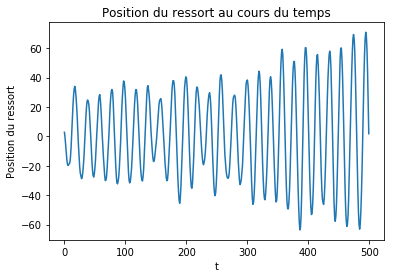

In [32]:
i = 10
data = np.array(all_simus[i]['simu'][4, :])
simu_ressort.plot_ressort(data, all_simus[i]['F'], all_simus[i]['k'])

In [33]:
print(descriptor.compute_descriptor(data))

[  1.07427236e+00   3.04897404e+01  -6.36288689e+01   7.09017869e+01
   5.00000000e-02   8.69675892e+03]


## 2. Apprendre `(F, k)` avec une regression linéaire
Pour trouver les poids des descripteurs

In [15]:
def train_regr_lin(X_train, Y_train, X_test, Y_test):
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)

    y_pred = regr.predict(X_test)
    print("MSE on test set:", mean_squared_error(y_pred, Y_test))

In [16]:
train_regr_lin(X_train, Y_train, X_test, Y_test)

MSE on test set: 2.47978983371e+21


Erreur assez chaud... 

A tester avec les coef de Fourrier 

#### Prédiction de `F`

In [17]:
train_regr_lin(X_train, Y_train[:, 0], X_test, Y_test[:, 0])

MSE on test set: 3.20138043367e+21


#### Prédiction de `k`

In [18]:
train_regr_lin(X_train, Y_train[:, 1], X_test, Y_test[:, 1])

MSE on test set: 1.75819922893e+21


## 3. ACP

In [19]:
from sklearn.decomposition import PCA

#### Projection en 2D

In [20]:
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(X_data)
principal_df = pd.DataFrame(data=principal_comp, columns=['principal component 1', 'principal component 2'])
principal_df['target'] = Y_data[:, 0]

In [21]:
principal_df.head()

,principal component 1,principal component 2,target
0,-0.025813,0.340642,0.0
1,-0.025813,0.340642,0.0
2,-0.025813,0.340642,0.0
3,-0.025813,0.340642,0.0
4,-0.025813,0.340642,0.0


In [22]:
pca.explained_variance_ratio_

array([ 0.83340174,  0.16659826])

-> La première composante contient 80% de la variance, et la deuxième 20%

In [23]:
pca.components_

array([[ 0.44719065,  0.44719065, -0.44719065,  0.44719065,  0.0101288 ,
         0.44719065],
       [ 0.00452974,  0.00452974, -0.00452974,  0.00452974, -0.9999487 ,
         0.00452974]])

-> Coordonnées des premières et deuxiemes composantes principales dans l'espace des descripteurs

ACP pour faire de la réduction de dimension: projetter sur un certains nb de composntes principales (nb < au nb de coord)

In [ ]:
import numpy as np

V = all_simus[0]['simu'][0,  :100]
print(V.shape)
freq = np.fft.fftfreq(len(V))

In [ ]:
freq

In [ ]:
signal = np.fft.fft(V)

In [ ]:
signal

In [ ]:
fr_max = freq[np.argmax(signal)]
fr_max